Import modules

In [1]:
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

Set data file paths

In [2]:
files = []
path = 'archive-2/lgg-mri-segmentation/kaggle_3m/'

# the ground truth are files marked with 'mask'
mask_files = glob.glob(path + '*/*_mask*')
data = pd.read_csv(path + "data.csv")
for i in mask_files:
    # for the truthful mask files, retrieve the blank image
    files.append(i.replace('_mask',''))

Assign labels to data

In [3]:
df = pd.DataFrame()
df['img']= files
df['mask']= mask_files

# label the classification from the masked files
def labels(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0:
        return 1
    else: return 0

df['label'] = df['mask'].apply(labels)
print("Number of non tumours: " + str(df.label.value_counts()[0]))
print("Number of tumours: " + str(df.label.value_counts()[1]))

Number of non tumours: 2556
Number of tumours: 1373


Since the number of classifications are somewhat evenly distributed, we can directly use the whole dataset.

In [4]:
df

,img,mask,label
0,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
1,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1
2,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1
3,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1
4,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,1
...,...,...,...
3924,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
3925,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
3926,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0
3927,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,archive-2/lgg-mri-segmentation/kaggle_3m\TCGA_...,0


Load and preprocess image data

In [5]:
# downsize the input images
def downsample_and_split(train_size):
    images = []
    masks = []

    # image size
    size = 32, 32

    # use only tumour images
    tumour_df = df[df['label'] == 1]

    # Iterate through each tumour image in each subfolder
    for index in tumour_df.index:
        img = tumour_df['img'][index]
        temp_img = cv2.imread(img, cv2.IMREAD_UNCHANGED)

        mask = tumour_df['mask'][index]
        temp_mask = cv2.imread(mask)

        if temp_img is None:
            continue

        # Resize the images
        temp_img = cv2.resize(temp_img, size)
        images.append(temp_img)

        temp_mask = cv2.resize(temp_mask, size)
        masks.append(temp_mask)

    # Convert images to a numpy array
    images = np.array(images)

    # Normalize the images
    images = images.astype('float32')/255.0

    # Split images into training and testing datasets
    images_train = images[:int((images.shape[0]+1)*train_size)]
    images_test = images[int((images.shape[0]+1)*train_size):]

    # Convert masks to a numpy array
    masks = np.array(masks)

    # Normalize the masks
    masks = masks.astype('float32')/255.0

    # Split masks into training and testing datasets
    masks_train = masks[:int((masks.shape[0]+1)*train_size)]
    masks_test = masks[int((masks.shape[0]+1)*train_size):]

    return images_train, masks_train, images_test, masks_test


Define and create the U-Net convolutional neural network

In [6]:
# Define the input and output shapes
input_shape = (32, 32, 3)
output_shape = (32, 32, 3)

# Define the U-Net architecture
inputs = Input(input_shape)
conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

Create 80% training and 20% testing split

In [7]:
X_train, Y_train, x_test, y_test = downsample_and_split(0.8)  # function to load and preprocess dataset and mask

Define Dice coefficient functions and train model

In [14]:
def dice_coefficient(y_true, y_pred, smooth=100):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

model.compile(optimizer='adam', loss=dice_coefficient_loss, metrics=[dice_coefficient])
model.fit(X_train, Y_train, batch_size=15, epochs=20, validation_split=0.1)

Epoch 1/20
66/66 [==============================] - 44s 499ms/step - loss: 0.1629 - dice_coefficient: 0.8371 - val_loss: 0.2541 - val_dice_coefficient: 0.7541
Epoch 2/20
66/66 [==============================] - 31s 466ms/step - loss: 0.1582 - dice_coefficient: 0.8418 - val_loss: 0.1867 - val_dice_coefficient: 0.8181
Epoch 3/20
66/66 [==============================] - 31s 465ms/step - loss: 0.1453 - dice_coefficient: 0.8547 - val_loss: 0.1779 - val_dice_coefficient: 0.8280
Epoch 4/20
66/66 [==============================] - 31s 467ms/step - loss: 0.1393 - dice_coefficient: 0.8607 - val_loss: 0.1825 - val_dice_coefficient: 0.8249
Epoch 5/20
66/66 [==============================] - 31s 471ms/step - loss: 0.1329 - dice_coefficient: 0.8671 - val_loss: 0.1745 - val_dice_coefficient: 0.8308
Epoch 6/20
66/66 [==============================] - 31s 476ms/step - loss: 0.1293 - dice_coefficient: 0.8707 - val_loss: 0.1603 - val_dice_coefficient: 0.8457
Epoch 7/20
66/66 [============================

Predict masks from test images

In [15]:
Y_pred = model.predict(x_test)

9/9 [==============================] - 2s 118ms/step


Plot predicted masks

Text(0.5, 1.0, 'Pred Mask 105')

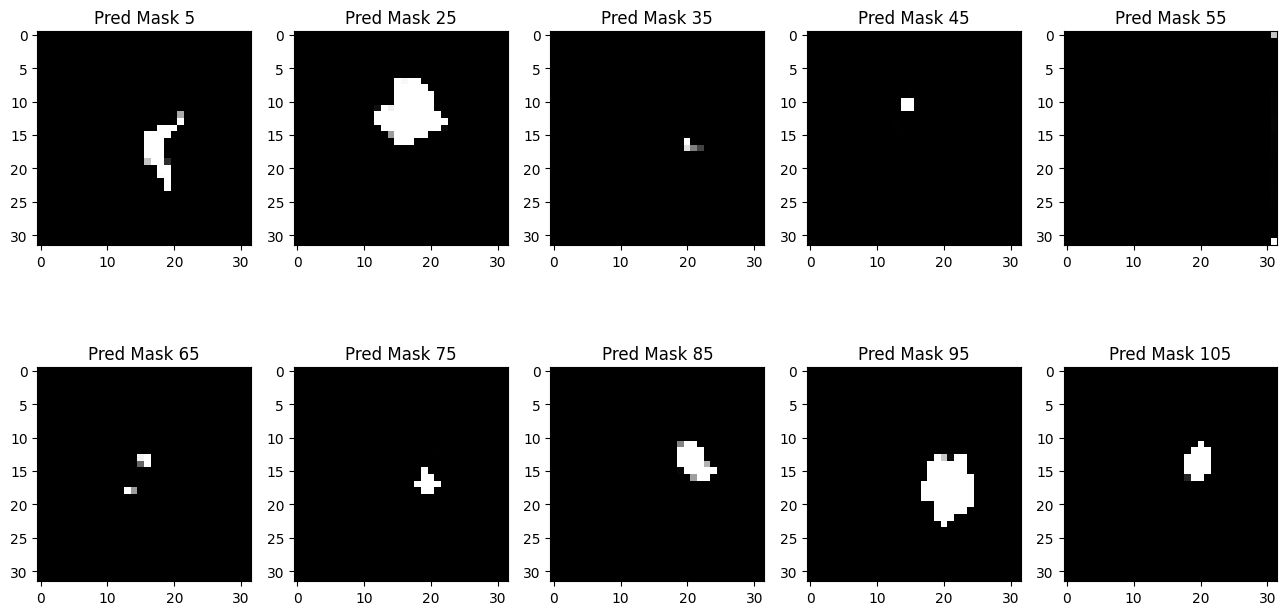

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(251)
plt.imshow(Y_pred[5,:,:,0],cmap="gray")
plt.title('Pred Mask 5')
plt.subplot(252)
plt.imshow(Y_pred[25,:,:,0],cmap="gray")
plt.title('Pred Mask 25')
plt.subplot(253)
plt.imshow(Y_pred[35,:,:,0],cmap="gray")
plt.title('Pred Mask 35')
plt.subplot(254)
plt.imshow(Y_pred[45,:,:,0],cmap="gray")
plt.title('Pred Mask 45')
plt.subplot(255)
plt.imshow(Y_pred[55,:,:,0],cmap="gray")
plt.title('Pred Mask 55')
plt.subplot(256)
plt.imshow(Y_pred[65,:,:,0],cmap="gray")
plt.title('Pred Mask 65')
plt.subplot(257)
plt.imshow(Y_pred[75,:,:,0],cmap="gray")
plt.title('Pred Mask 75')
plt.subplot(258)
plt.imshow(Y_pred[85,:,:,0],cmap="gray")
plt.title('Pred Mask 85')
plt.subplot(259)
plt.imshow(Y_pred[95,:,:,0],cmap="gray")
plt.title('Pred Mask 95')
plt.subplot(2,5,10)
plt.imshow(Y_pred[105,:,:,0],cmap="gray")
plt.title('Pred Mask 105')

Plot test images

Text(0.5, 1.0, 'Test Image 105')

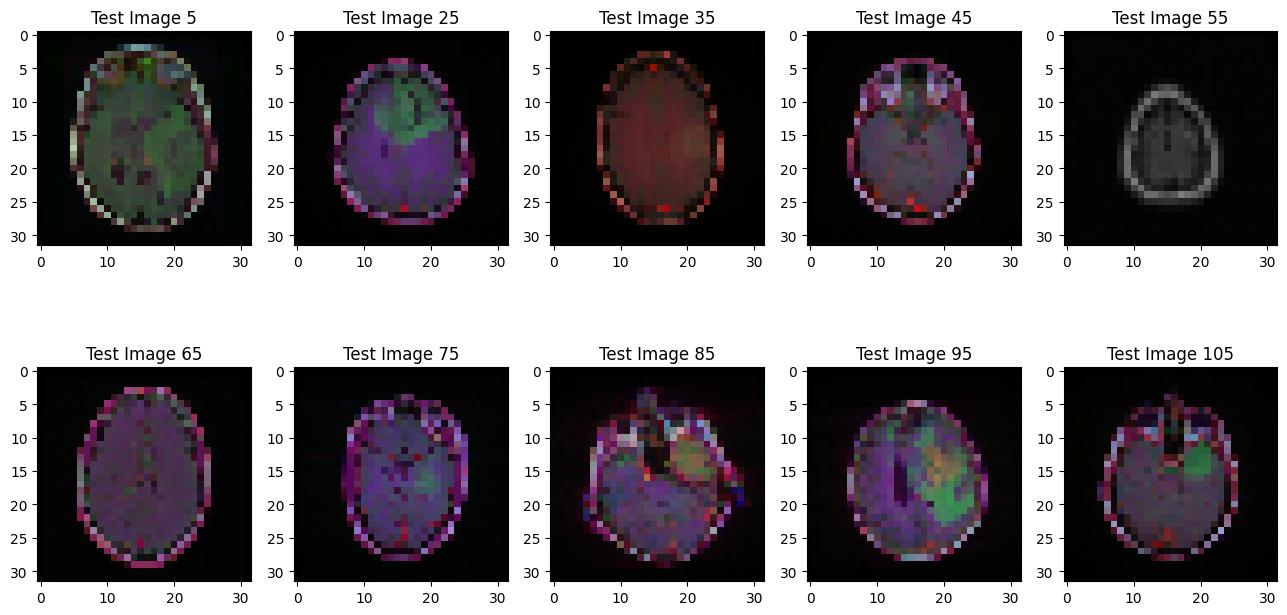

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(251)
plt.imshow(x_test[5])
plt.title('Test Image 5')
plt.subplot(252)
plt.imshow(x_test[25])
plt.title('Test Image 25')
plt.subplot(253)
plt.imshow(x_test[35])
plt.title('Test Image 35')
plt.subplot(254)
plt.imshow(x_test[45])
plt.title('Test Image 45')
plt.subplot(255)
plt.imshow(x_test[55])
plt.title('Test Image 55')
plt.subplot(256)
plt.imshow(x_test[65])
plt.title('Test Image 65')
plt.subplot(257)
plt.imshow(x_test[75])
plt.title('Test Image 75')
plt.subplot(258)
plt.imshow(x_test[85])
plt.title('Test Image 85')
plt.subplot(259)
plt.imshow(x_test[95])
plt.title('Test Image 95')
plt.subplot(2,5,10)
plt.imshow(x_test[105])
plt.title('Test Image 105')

Plot test masks

Text(0.5, 1.0, 'Test Mask 105')

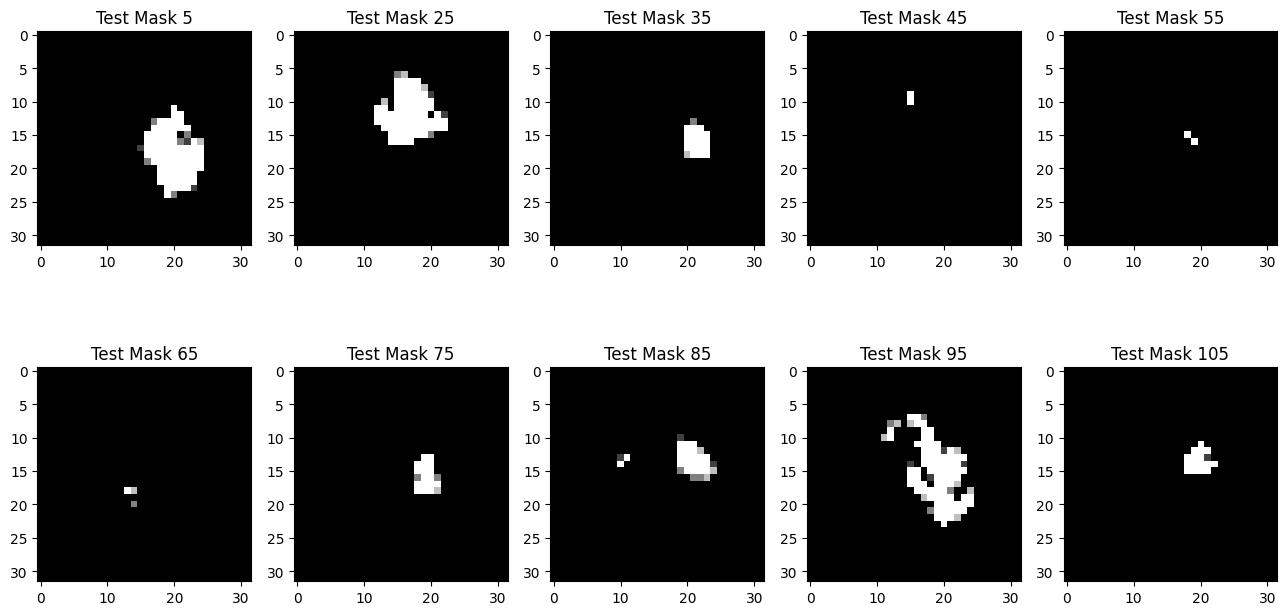

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(251)
plt.imshow(y_test[5])
plt.title('Test Mask 5')
plt.subplot(252)
plt.imshow(y_test[25])
plt.title('Test Mask 25')
plt.subplot(253)
plt.imshow(y_test[35])
plt.title('Test Mask 35')
plt.subplot(254)
plt.imshow(y_test[45])
plt.title('Test Mask 45')
plt.subplot(255)
plt.imshow(y_test[55])
plt.title('Test Mask 55')
plt.subplot(256)
plt.imshow(y_test[65])
plt.title('Test Mask 65')
plt.subplot(257)
plt.imshow(y_test[75])
plt.title('Test Mask 75')
plt.subplot(258)
plt.imshow(y_test[85])
plt.title('Test Mask 85')
plt.subplot(259)
plt.imshow(y_test[95])
plt.title('Test Mask 95')
plt.subplot(2,5,10)
plt.imshow(y_test[105])
plt.title('Test Mask 105')